## Initialisations

In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import tree 
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1Fsl9G_C7ZzRn0VpfpF8CjuXkdC18Y6Vf/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
compas_df = pd.read_csv(url, sep=',')

## Preprocessing

In [ ]:
compas_df['DateOfBirth'] = compas_df['DateOfBirth'].str[6:]
compas_df['DateOfBirth'] = pd.to_numeric(compas_df['DateOfBirth'])
compas_df['DateOfBirth'] = compas_df['DateOfBirth'] + 1900

In [ ]:
compas_df["Age"] = 2016 - compas_df["DateOfBirth"]

In [ ]:
compas_df['ScoreText'].replace('High', 'Medium_High', inplace=True)
compas_df['ScoreText'].replace('Medium', 'Medium_High', inplace=True)

In [ ]:
compas_df = compas_df.drop(columns=["Person_ID","AssessmentID","Case_ID","FirstName","MiddleName","LastName","DateOfBirth","ScaleSet_ID","Screening_Date","AssessmentReason","RecSupervisionLevel","Scale_ID","IsCompleted","IsDeleted"])

In [ ]:
compas_df = compas_df.drop(columns=["DecileScore","RecSupervisionLevelText","RawScore"])

In [ ]:
compas_df = compas_df.dropna()

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Unknown']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Other']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Oriental']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Arabic']

In [ ]:
compas_df['Ethnic_Code_Text'].replace('African-Am', 'African-American', inplace=True)

## Label Encoder

In [ ]:
le = LabelEncoder()
compas_df.Agency_Text = le.fit_transform(compas_df.Agency_Text)
compas_df.Sex_Code_Text = le.fit_transform(compas_df.Sex_Code_Text)
compas_df.Ethnic_Code_Text = le.fit_transform(compas_df.Ethnic_Code_Text)
compas_df.ScaleSet = le.fit_transform(compas_df.ScaleSet)
compas_df.Language = le.fit_transform(compas_df.Language)
compas_df.LegalStatus = le.fit_transform(compas_df.LegalStatus)
compas_df.CustodyStatus = le.fit_transform(compas_df.CustodyStatus)
compas_df.MaritalStatus = le.fit_transform(compas_df.MaritalStatus)
compas_df.DisplayText = le.fit_transform(compas_df.DisplayText)
compas_df.ScoreText = le.fit_transform(compas_df.ScoreText)
compas_df.AssessmentType = le.fit_transform(compas_df.AssessmentType)

## Partitioning

In [ ]:
# partition the caucasion subgroup from the rest
compas_df_caucasian = compas_df.copy()
compas_df_caucasian = compas_df_caucasian[compas_df_caucasian['Ethnic_Code_Text'] == 2]
compas_df_caucasian.groupby('ScoreText',sort=False).size()

ScoreText
0    15291
1     5145
dtype: int64

In [ ]:
# sample the partition
compas_df_caucasian = compas_df_caucasian.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(5145, random_state=64))

In [ ]:
# partition the african american subgroup from the rest
compas_df_africanamer = compas_df.copy()
compas_df_africanamer = compas_df_africanamer[compas_df_africanamer['Ethnic_Code_Text'] == 0]
compas_df_africanamer.groupby('ScoreText',sort=False).size()

ScoreText
1    11155
0    14588
dtype: int64

In [ ]:
# sample the partition
compas_df_africanamer = compas_df_africanamer.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(11155, random_state=64))

In [ ]:
# partition the hispanic subgroup from the rest
compas_df_hispanic = compas_df.copy()
compas_df_hispanic = compas_df_hispanic[compas_df_hispanic['Ethnic_Code_Text'] == 3]
compas_df_hispanic.groupby('ScoreText',sort=False).size()

ScoreText
1    1544
0    5416
dtype: int64

In [ ]:
# sample the partition
compas_df_hispanic = compas_df_hispanic.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(1544, random_state=64))

In [ ]:
# partition the asian subgroup from the rest
compas_df_asian = compas_df.copy()
compas_df_asian = compas_df_asian[compas_df_asian['Ethnic_Code_Text'] == 1]
compas_df_asian.groupby('ScoreText',sort=False).size()

ScoreText
1     43
0    248
dtype: int64

In [ ]:
# sample the partition
compas_df_asian = compas_df_asian.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(43, random_state=64))

In [ ]:
# partition the native american subgroup from the rest
compas_df_nativeamer = compas_df.copy()
compas_df_nativeamer = compas_df_nativeamer[compas_df_nativeamer['Ethnic_Code_Text'] == 4]
compas_df_nativeamer.groupby('ScoreText',sort=False).size()

ScoreText
0    128
1     70
dtype: int64

In [ ]:
# sample the partition
compas_df_nativeamer = compas_df_nativeamer.groupby('ScoreText', group_keys=False).apply(lambda x: x.sample(70, random_state=64))

## Caucasian Only Decision Tree Model

In [ ]:
X = compas_df_caucasian.drop('ScoreText',axis=1)
y = compas_df_caucasian[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(6860, 11)
Test data shape:(3430, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
52906,3,1,2,1,0,4,0,1,1,1,48
23457,2,1,2,1,0,4,2,4,2,1,44
22531,2,1,2,1,0,4,0,4,1,1,55
55280,2,1,2,1,0,3,4,4,0,1,26
4326,3,1,2,1,0,3,4,4,2,1,25


In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dt_model_accuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'random'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=0.03,
                                   max_depth=10,
                                   max_features = None,
                                   min_samples_leaf=10,
                                   random_state = 0,
                                   splitter='random')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       min_samples_split=0.03, random_state=0,
                       splitter='random')

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
cauc_accuracy = accuracy_score(y_test,pred)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1715
           1       0.70      0.74      0.72      1715

    accuracy                           0.71      3430
   macro avg       0.71      0.71      0.71      3430
weighted avg       0.71      0.71      0.71      3430



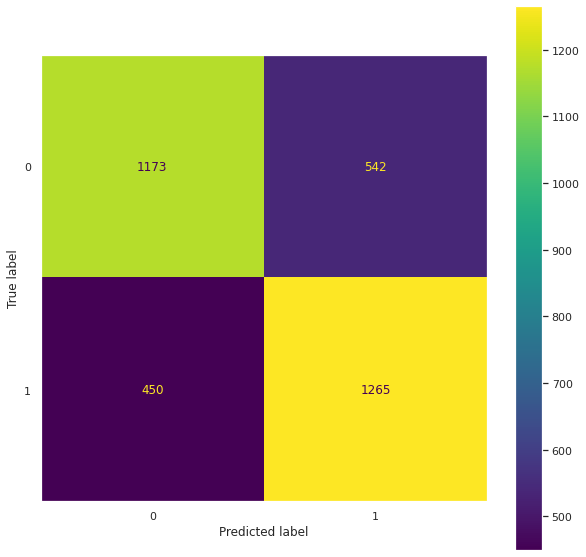

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

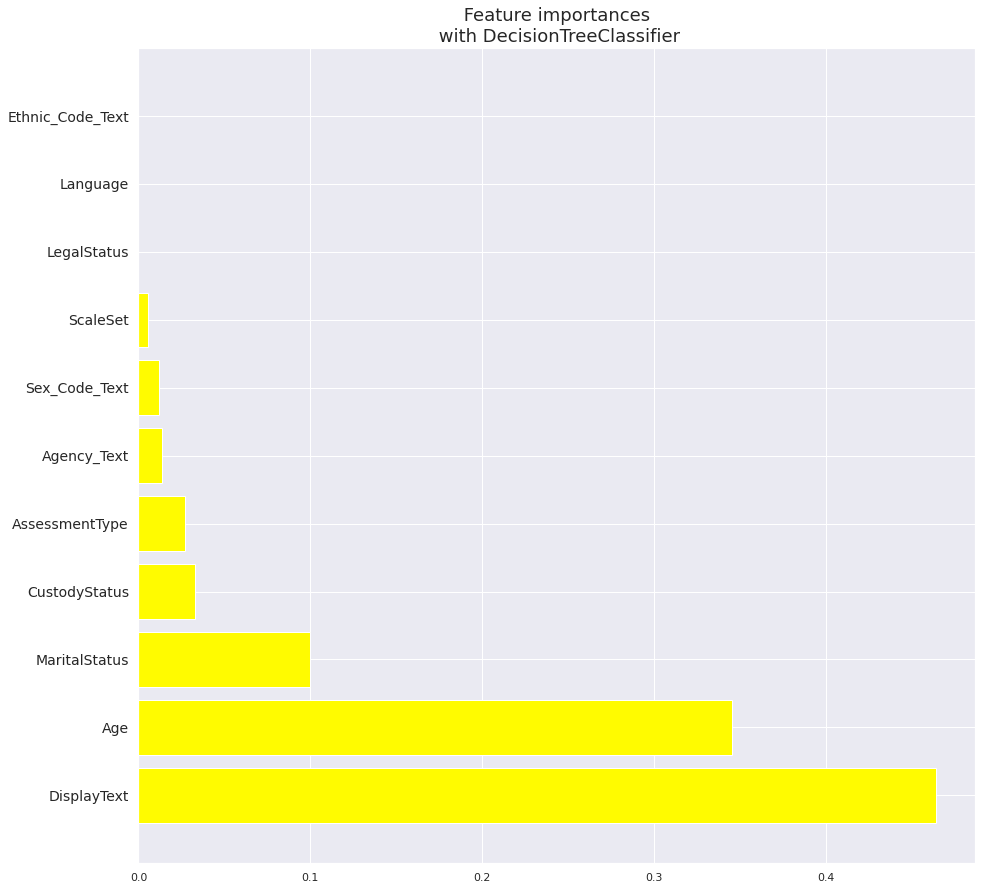

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df_caucasian.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## African-American Only Decision Tree Model

In [ ]:
X = compas_df_africanamer.drop('ScoreText',axis=1)
y = compas_df_africanamer[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(14874, 11)
Test data shape:(7436, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
3031,2,1,0,1,0,4,2,4,1,0,29
18581,2,0,0,1,0,4,0,4,0,1,41
8702,2,1,0,1,0,4,0,4,0,1,22
29016,2,0,0,1,0,4,0,4,2,1,42
38819,3,1,0,1,0,3,4,4,0,1,37


In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dt_model_accuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=0.03,
                                   max_depth=10,
                                   max_features = None,
                                   min_samples_leaf=5,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=0.03, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
afr_accuracy = accuracy_score(y_test,pred)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      3718
           1       0.70      0.65      0.68      3718

    accuracy                           0.69      7436
   macro avg       0.69      0.69      0.69      7436
weighted avg       0.69      0.69      0.69      7436



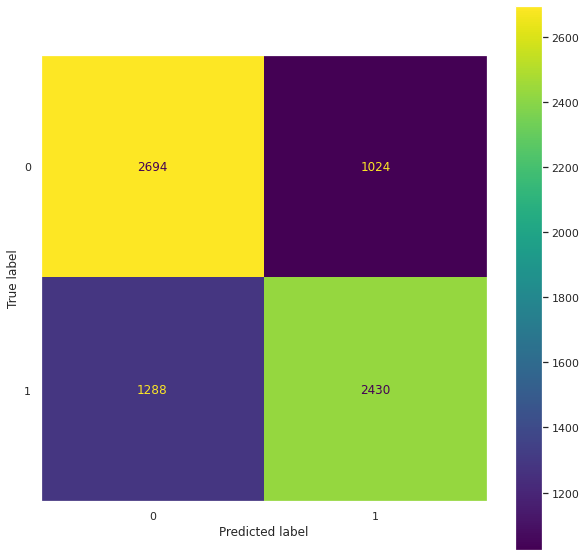

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

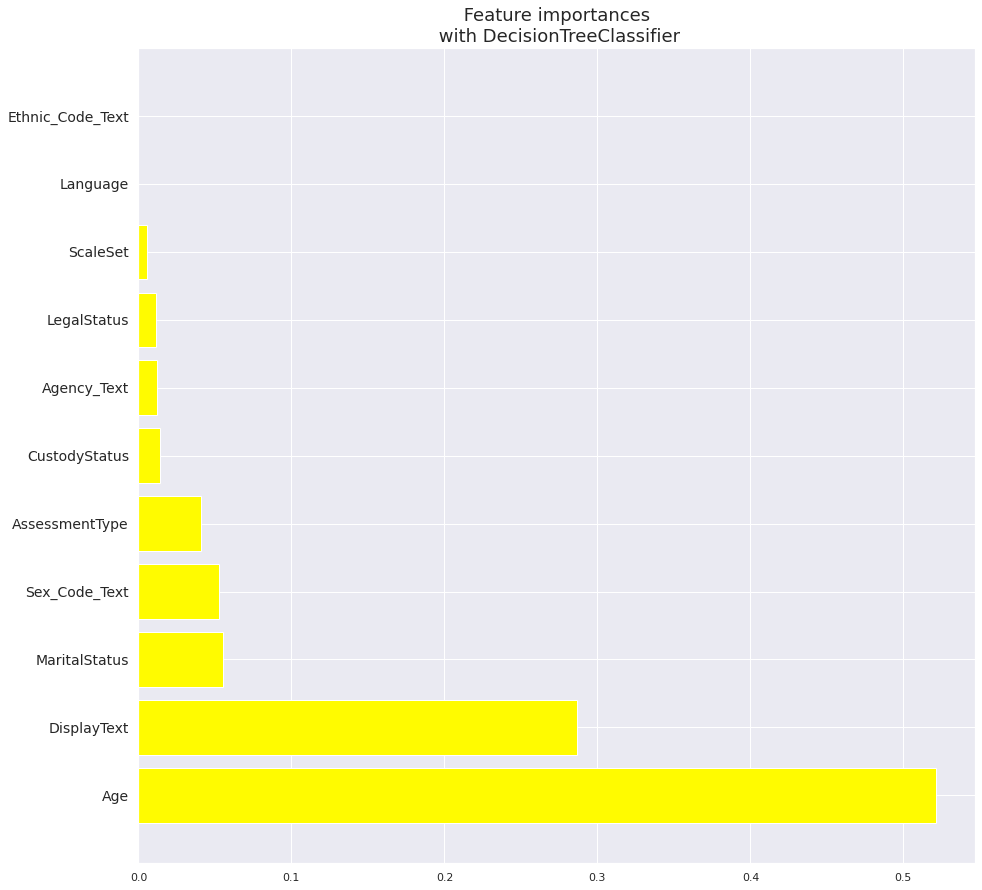

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df_africanamer.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Hispanic Only Decision Tree Model

In [ ]:
X = compas_df_hispanic.drop('ScoreText',axis=1)
y = compas_df_hispanic[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(2059, 11)
Test data shape:(1029, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
15535,2,1,3,1,1,4,2,4,1,1,65
39657,2,1,3,1,0,4,0,2,2,1,47
19677,3,1,3,1,0,3,4,4,2,1,30
38514,2,0,3,1,0,4,0,1,2,1,52
7088,2,1,3,1,0,4,0,4,0,1,33


In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dt_model_accuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 0.05, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=0.05,
                                   max_depth=6,
                                   max_features = None,
                                   min_samples_leaf=10,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=10,
                       min_samples_split=0.05, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
his_accuracy = accuracy_score(y_test,pred)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       514
           1       0.71      0.63      0.66       515

    accuracy                           0.68      1029
   macro avg       0.68      0.68      0.68      1029
weighted avg       0.68      0.68      0.68      1029



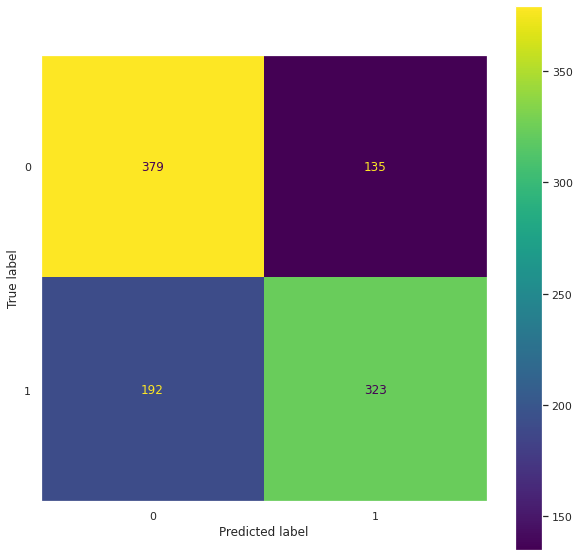

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

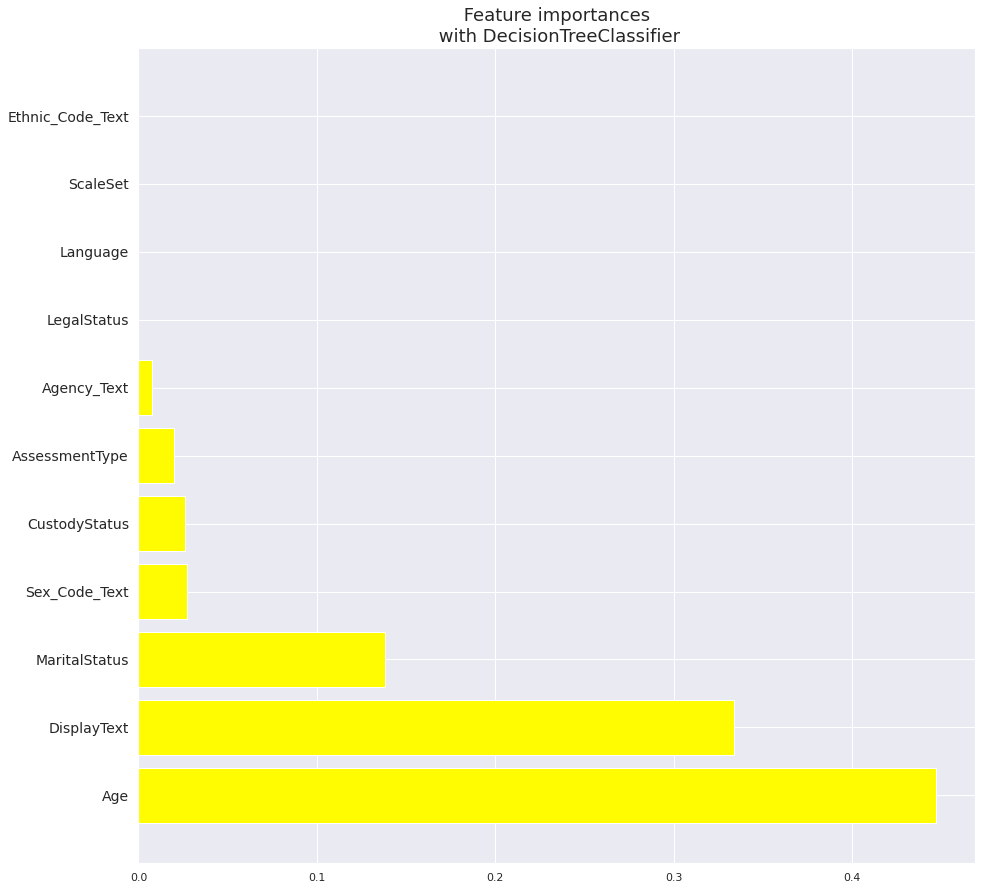

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df_hispanic.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Asian Only Decision Tree Model

In [ ]:
X = compas_df_asian.drop('ScoreText',axis=1)
y = compas_df_asian[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(58, 11)
Test data shape:(28, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
47097,2,0,1,1,0,4,2,0,2,1,43
7506,2,1,1,1,0,4,0,4,2,1,47
49389,3,1,1,1,0,3,4,4,2,1,25
54047,2,1,1,1,0,4,0,0,0,1,62
18138,3,1,1,1,0,3,4,4,2,1,67


In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dt_model_accuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'random_state': 0, 'splitter': 'random'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='entropy',
                                   min_samples_split=0.05,
                                   max_depth=6,
                                   max_features = 'auto',
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='random')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='auto',
                       min_samples_split=0.05, random_state=0,
                       splitter='random')

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
asi_accuracy = accuracy_score(y_test,pred)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73        14
           1       0.75      0.64      0.69        14

    accuracy                           0.71        28
   macro avg       0.72      0.71      0.71        28
weighted avg       0.72      0.71      0.71        28



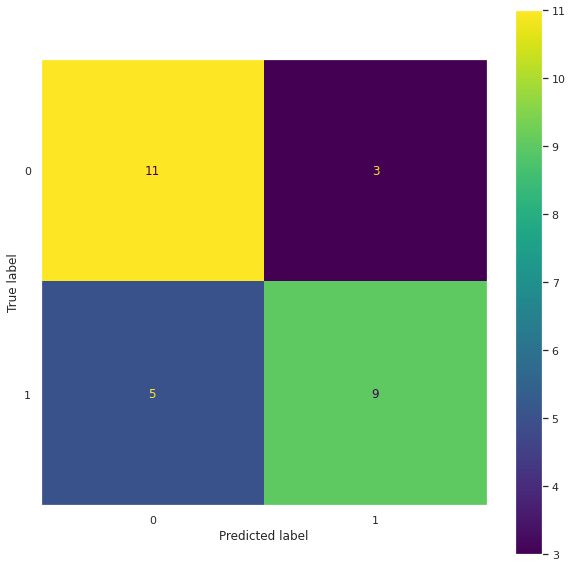

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

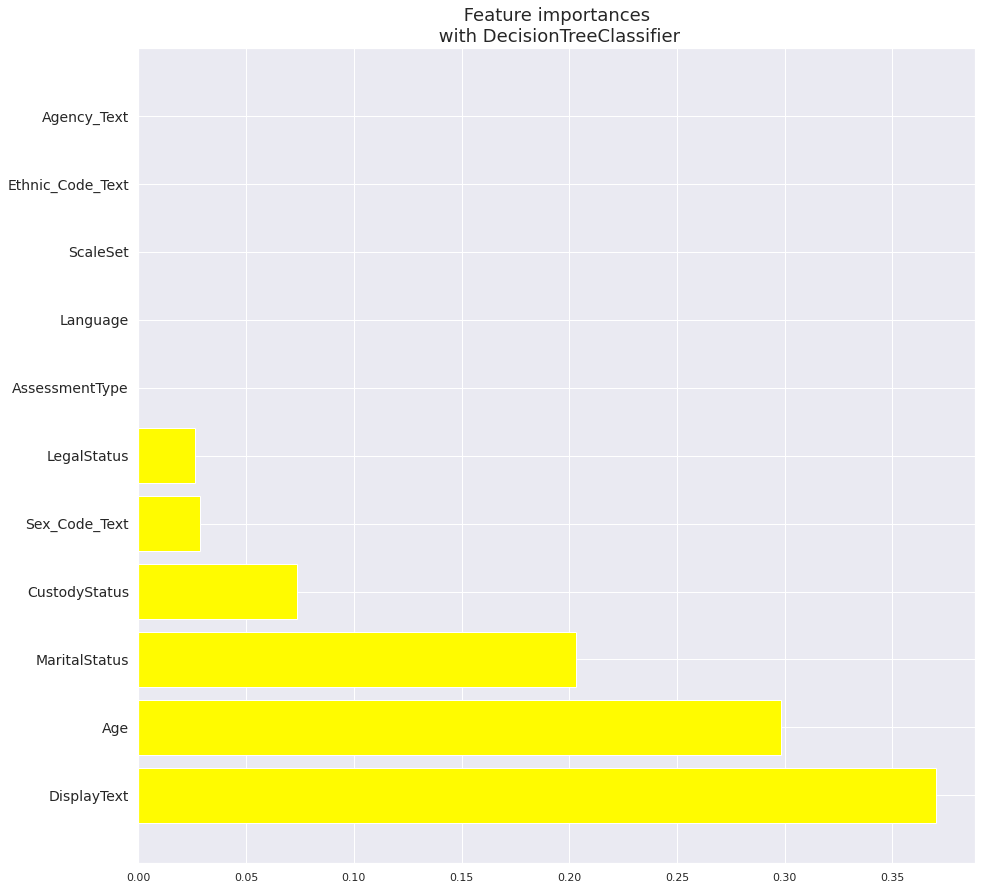

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df_asian.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Native American Only Decision Tree Model

In [ ]:
X = compas_df_nativeamer.drop('ScoreText',axis=1)
y = compas_df_nativeamer[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(94, 11)
Test data shape:(46, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
32816,2,0,4,1,0,4,2,4,0,0,35
6715,2,0,4,1,0,4,0,0,1,1,46
52714,2,0,4,1,0,4,0,4,1,1,25
60618,2,1,4,1,0,4,0,4,2,1,72
14867,2,1,4,1,0,4,0,4,0,1,27


In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dt_model_accuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=10,
                                   max_features = 'auto',
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=10, max_features='auto', random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
nat_accuracy = accuracy_score(y_test,pred)

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.60      0.52      0.56        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46



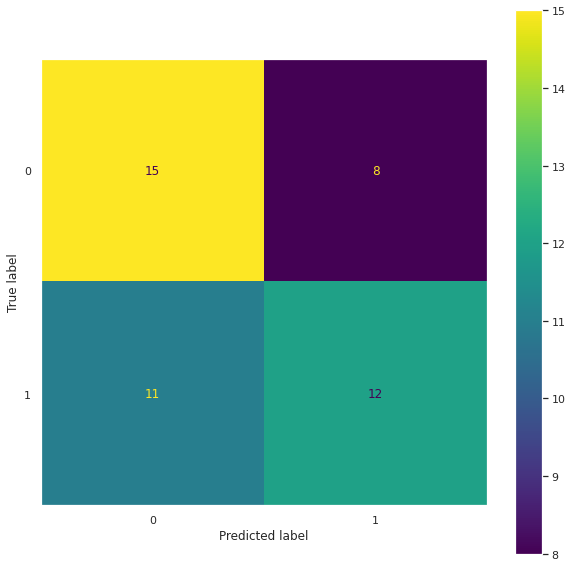

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

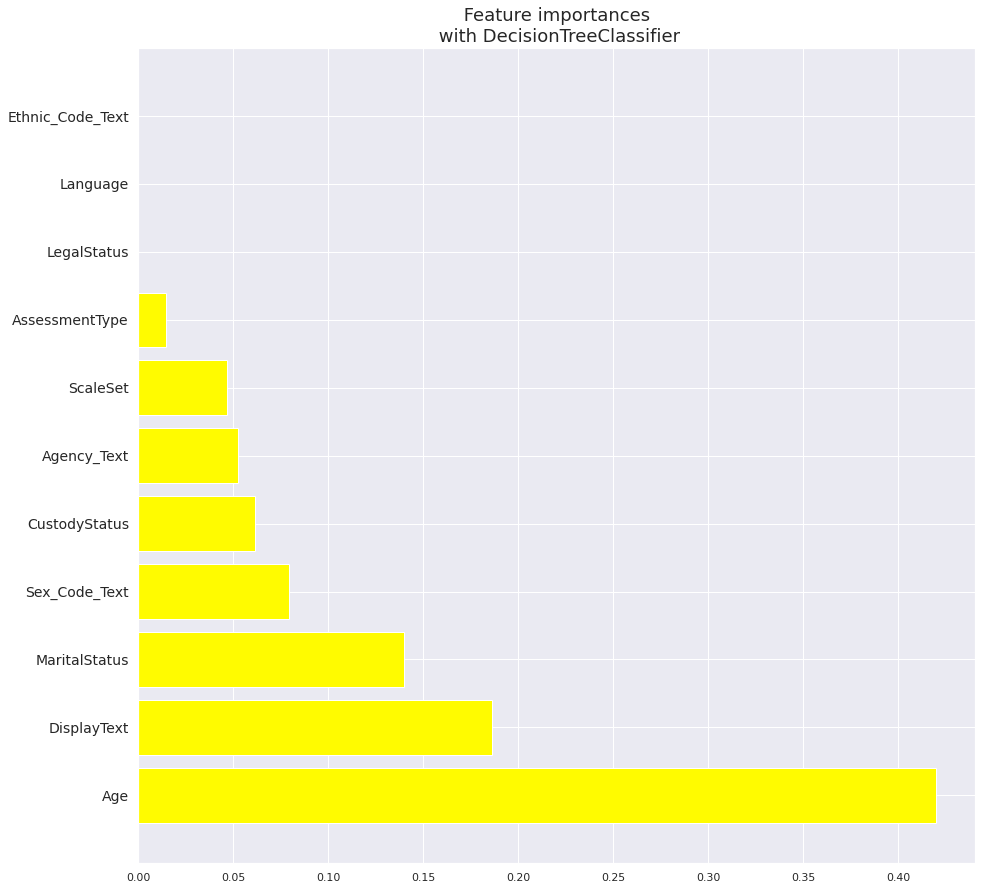

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df_nativeamer.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()

## Accuracy Comparison Tables

In [ ]:
from tabulate import tabulate
data = [['Caucasian', cauc_accuracy],
['African-American', afr_accuracy],
['Hispanic', his_accuracy],
['Asian', asi_accuracy],
['Native-American', nat_accuracy],
]
print (tabulate(data, headers=["Ethnicity", "Classification Accuracy"]))

Ethnicity           Classification Accuracy
----------------  -------------------------
Caucasian                          0.710787
African-American                   0.68908
Hispanic                           0.682216
Asian                              0.714286
Native-American                    0.586957
